OVSeg
====

 **Open-Vocabulary Semantic Segmentation with Mask-adapted CLIP**

* Paper: https://arxiv.org/abs/2210.04150

![OVSeg Overview](../assets/ovseg_overview.jpg)
![OVSeg Prompting](../assets/ovseg_prompt.jpg)
![OVSeg Two-Stage](../assets/ovseg_twostage.jpg)
![OVSeg Image-Text](../assets/ovseg_imgtextmatching.jpg)



 * Installation

```bash
git clone https://github.com/facebookresearch/ov-seg.git OVSeg_repo

cd OVSeg_repo

conda create --name ovseg python=3.8 -y
conda activate ovseg
conda install pytorch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1 cudatoolkit=11.3 -c pytorch -c conda-forge
pip install -r requirements.txt


python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html


cd third_party/CLIP
python -m pip install -Ue .
```

* Download model: https://drive.google.com/file/d/1cn-ohxgXDrDfkzC1QdO-fi8IjbjXmgKy/view

```bash
pip install -U gdown
```

```python
gdown --id 1cn-ohxgXDrDfkzC1QdO-fi8IjbjXmgKy
```

In [1]:
import os
import sys
import time

import cv2
from tqdm import tqdm
import torch
import numpy as np
from detectron2.utils.visualizer import ColorMode

from detectron2.config import get_cfg

from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger

sys.path.append("OVSeg_repo")
from open_vocab_seg import add_ovseg_config
#from open_vocab_seg.utils import VisualizationDemo
from open_vocab_seg import utils

# constants
WINDOW_NAME = "Open vocabulary segmentation"


def setup_cfg():
    # load config from file and command-line arguments
    cfg = get_cfg()
    # for poly lr schedule
    add_deeplab_config(cfg)
    add_ovseg_config(cfg)
    cfg.merge_from_file(CONFIG_FILE)
    cfg.merge_from_list(OPTS)
    cfg.freeze()
    return cfg

/home/pyml/anaconda3/envs/ovseg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pyml/anaconda3/envs/ovseg/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/pyml/git_vmirly/GenAI-Hub/tmp/ov-seg/third_party/CLIP/clip/clip.py:25: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [2]:
CONFIG_FILE = "OVSeg_repo/configs/ovseg_swinB_vitL_demo.yaml"
OPTS = ["MODEL.WEIGHTS", "ovseg_swinbase_vitL14_ft_mpt.pth"]

cfg = setup_cfg()

cfg

Loading config OVSeg_repo/configs/ovseg_swinB_vitL_demo.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'OVSegDEMO', 'WEIGHTS': 'ovseg_swinbase_vitL14_ft_mpt.pth', 'PIXEL_MEAN': [123.675, 116.28, 103.53], 'PIXEL_STD': [58.395, 57.12, 57.375], 'BACKBONE': CfgNode({'NAME': 'D2SwinTransformer', 'FREEZE_AT': 0}), 'FPN': CfgNode({'IN_FEATURES': [], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 64, 128, 256, 512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['res4'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1', 'BBOX_REG_LOSS_WEIGHT': 1.0, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 1.0), 'SMO

In [3]:
from PIL import Image
img_orig = Image.open("../samples/plants.jpg")
w, h = img_orig.size
img_orig.resize((int(w/2), int(h/2))).save("plants_small.jpg")

input_path = "plants_small.jpg"
class_names = ["plant", "leaf", "pot", "vase"]
img = read_image(input_path, format="BGR")
img.shape

(568, 534, 3)

In [4]:
metadata = MetadataCatalog.get(
    cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
)

cpu_device = torch.device("cpu")
instance_mode = ColorMode.IMAGE

predictor = utils.predictor.OVSegPredictor(cfg)

/home/pyml/anaconda3/envs/ovseg/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
def run_on_image(image, class_names):
    predictions = predictor(image, class_names)
    # Convert image from OpenCV BGR format to Matplotlib RGB format.
    image = image[:, :, ::-1]
    #visualizer = OVSegVisualizer(image, self.metadata, instance_mode=self.instance_mode, class_names=class_names)
    if "sem_seg" in predictions:
        r = predictions["sem_seg"]
        blank_area = (r[0] == 0)
        pred_mask = r.argmax(dim=0).to('cpu')
        pred_mask[blank_area] = 255
        pred_mask = np.array(pred_mask, dtype="int32")

        #vis_output = visualizer.draw_sem_seg(
        #    pred_mask
        #)
    else:
        raise NotImplementedError

    return predictions#, vis_output

image = read_image(input_path)
preds = run_on_image(image, class_names)
print(preds.keys())

/home/pyml/anaconda3/envs/ovseg/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/pyml/git_vmirly/GenAI-Hub/OVSeg/OVSeg_repo/open_vocab_seg/modeling/transformer/position_encoding.py:47: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roun

dict_keys(['sem_seg'])


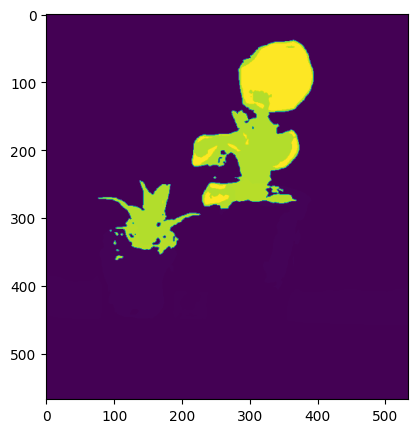

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(preds["sem_seg"][0].cpu().numpy())
plt.show()

/home/pyml/anaconda3/envs/ovseg/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/pyml/git_vmirly/GenAI-Hub/OVSeg/OVSeg_repo/open_vocab_seg/modeling/transformer/position_encoding.py:47: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roun

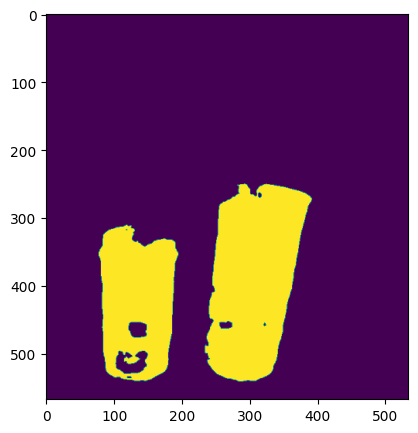

In [7]:
image = read_image(input_path)
preds = run_on_image(image, ["vase"])

fig = plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(preds["sem_seg"][0].cpu().numpy())
plt.show()